In [ ]:
# Testing a hierarchical path-finding algorithm 
# which is extended version of the a* path-finding.
# The main idea is to use a hierarchical quadra-grid as data structure and
# modified heuristic which depends on clusters density

In [1099]:
import numpy as np
import pandas as pd
import random
from queue import PriorityQueue
import time
import csv
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output

In [1165]:
def hpr(point, level):
    return tuple(map(lambda x: x >> level, point));

def hpr2(point, level):
    return (point[0] >> level, point[1] >> level);

class Grid:
    def __init__(self, dim, n):
        self.dim = dim
        self.n = n
        self.cells = np.zeros((n,)*dim)

    
class Grid2d(Grid):
     def __init__(self, n):
            super(self.__class__, self).__init__(2, n)
            
class HierarchicalGrid2:
    
    @staticmethod
    def fill(hg, density, expect=[]):
        expect = set(expect)
        for i in range(0, len(hg.hierarchy[0].cells)):
            for j in range(0, len(hg.hierarchy[0].cells[0])):
                if (random.random() < density) and (i, j) not in expect:
                    hg.add((i, j), 1)
    
    def __init__(self, depth):
        self.dim = 2
        self.depth = depth
        self.hierarchy = []
        for level in range(0, depth):
            self.hierarchy.append(Grid(2, 1 << (depth - level - 1)))
            
    def add(self, point, val):
        for level in range(0, self.depth):
            self.hierarchy[level].cells[hpr2(point, level)] += val
            
    def get(self, point, level=0):
        return self.hierarchy[level].cells[hpr2(point, level)]
    
    def avg(self, point, level=0):
        return self.get(point, level) / (1 << level << level);
    
    def nbs(self, point):
        ps = []
        if point[0] > 0:
            a = list(point)
            a[0] -= 1
            ps.append(tuple(a))
        if point[0] < len(self.hierarchy[0].cells) - 1:
            b = list(point)
            b[0] += 1
            ps.append(tuple(b))
        if point[1] > 0:
            c = list(point)
            c[1] -= 1
            ps.append(tuple(c))
        if point[1] < len(self.hierarchy[0].cells) - 1:
            d = list(point)
            d[1] += 1
            ps.append(tuple(d))
        return ps
            
        

In [1242]:
def distance(a, b):
    return abs(a[0] - b[0]) + abs(a[1] - b[1])

def height(a, b):
    level = 0
    while hpr2(a, level) != hpr2(b, level): level += 1
    return level

def recostruct_path(paths, start, goal):
    path = [goal]
    a = goal
    while a != start:
        path.append(paths[a])
        a = paths[a]
    return path

def astar(hg, start, goal):
    start_time = time.time()
    costs = {}
    paths = {}
    queue = PriorityQueue()
    costs[start] = 0
    paths[start] = start
    queue.put((0, start))
    while not queue.empty():
        (p, a) = queue.get()
        if (a == goal):
            return { 'paths': paths , 'costs': costs, 'queue': queue, 'time_ms': (time.time() - start_time) * 1000 }
        for b in hg.nbs(a):
            if hg.get(b) < 1:
                cost = costs[a] + 1
                if b not in costs or cost < costs[b]:
                    costs[b] = cost
                    queue.put((cost + distance(b, goal), b))
                    paths[b] = a
    return None

def hastar(hg, start, goal):
    start_time = time.time()
    costs = {}
    paths = {}
    queue = PriorityQueue()
    costs[start] = 0
    paths[start] = start
    queue.put((0, start))
    while not queue.empty():
        (p, a) = queue.get()
        if (a == goal):
            return { 'paths': paths , 'costs': costs, 'queue': queue, 'time_ms': (time.time() - start_time) * 1000 }
        for b in hg.nbs(a):
            if hg.get(b) < 1:
                cost = costs[a] + 1
                if b not in costs or cost < costs[b]:
                    costs[b] = cost
                    queue.put((cost + distance(b, goal) / (1 - hg.avg(b, height(b, goal))), b))
                    paths[b] = a
    return None

In [1243]:
def test_alg(alg, hg, start, goal):
    res = alg(hg, start, goal)
    if res:
        res['alg'] = alg.__name__
        res['path_len'] = len(recostruct_path(res['paths'], start, goal))
    return res

def res_to_stats(res):
    if res:
        return {
            'alg': res['alg'],
            'path_len': res['path_len'],
            'visited_points': len(res['costs']),
            'queue_rest_size': res['queue'].qsize(),
            'time_ms': res['time_ms']
        }

In [1244]:
# Test

def test(depth, density, expt, algs, n):
    start = (random.randrange(1 << (depth - 1)), random.randrange(1 << (depth - 1)))
    goal = (random.randrange(1 << (depth - 1)), random.randrange(1 << (depth - 1)))
    hg = HierarchicalGrid2(depth)
    hg.fill(hg, density, [start, goal])
    expt.append({ 'N': n, 'depth': depth, 'density': density, 'distance': distance(start, goal) })
    for alg in [astar, castar, hastar]:
        res = res_to_stats(test_alg(alg, hg, start, goal))
        if res:
            res['N'] = n
            algs.append(res)

In [1257]:
# Initial condition

depth = 11
min_density = 0
max_density = 0.5
step = 0.01
iterations = 100

In [1258]:
# Run tests

# Test vars
total = iterations * (max_density - min_density) / step
n = 1
expt = []
algs = []
expt_name = "expt_d" + str(depth) + "_n" + str(iterations) + ".csv"
algs_name = "algs_d" + str(depth) + "_n" + str(iterations) + ".csv"

for density in np.arange(min_density, max_density, step):
    for i in range(0, iterations):
        print("Status: " + str(100 * n / total) + "%")
        clear_output(wait=True)
        test(depth, density, expt, algs, n)
        n += 1

Status: 100.0%


In [1259]:
# Write data as .csv

expt_keys = expt[0].keys()
with open(expt_name, 'w', newline='') as output_file:
    dict_writer = csv.DictWriter(output_file, expt_keys)
    dict_writer.writeheader()
    dict_writer.writerows(expt)

algs_keys = algs[0].keys()
with open(algs_name, 'w', newline='') as output_file:
    dict_writer = csv.DictWriter(output_file, algs_keys)
    dict_writer.writeheader()
    dict_writer.writerows(algs)


In [1251]:
# Load and preprocessing data

pd.set_option('display.max_rows', 1000)
algs = pd.read_csv(algs_name)
expt = pd.read_csv(expt_name)
df = pd.merge(expt, algs, how="left", on="N").dropna()
df_astar = df[df["alg"] == "astar"]
df_hastar = df[df["alg"] == "hastar"]
data = df.groupby(["density", "alg"])

In [1252]:
df_hastar.describe()

,N,depth,density,distance,path_len,visited_points,queue_rest_size,time_ms
count,3891.000000,3891.0,3891.000000,3891.000000,3891.000000,3891.000000,3891.000000,3891.000000
mean,1967.950912,9.0,0.191753,171.389103,194.873297,941.478026,263.642251,12.317003
std,1154.195309,0.0,0.115400,85.718744,101.137660,1991.124025,159.663341,29.634213
min,1.000000,9.0,0.000000,2.000000,3.000000,7.000000,4.000000,0.047922
25%,973.500000,9.0,0.090000,106.000000,119.000000,372.500000,144.000000,3.474951
50%,1950.000000,9.0,0.190000,164.000000,185.000000,616.000000,238.000000,6.018877
75%,2936.500000,9.0,0.290000,230.000000,258.000000,901.000000,353.000000,10.020614
max,4910.000000,9.0,0.490000,462.000000,1123.000000,45490.000000,1153.000000,556.242943


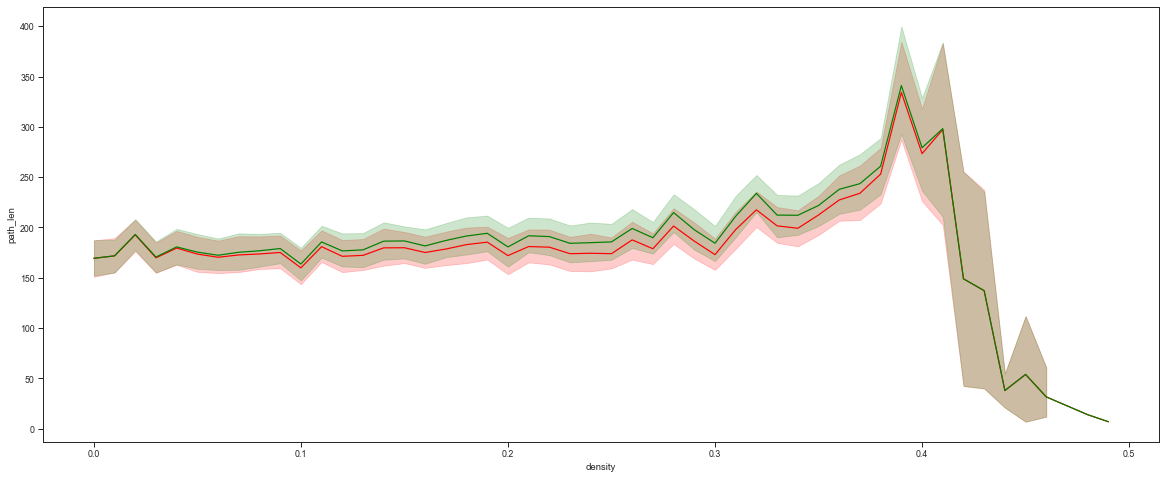

In [1253]:
plt.figure(figsize=(20,8))
sns.lineplot(x="density", y="path_len", data=df_astar, color="red")
sns.lineplot(x="density", y="path_len", data=df_hastar, color="green")
sns.set_context("paper")
plt.show()

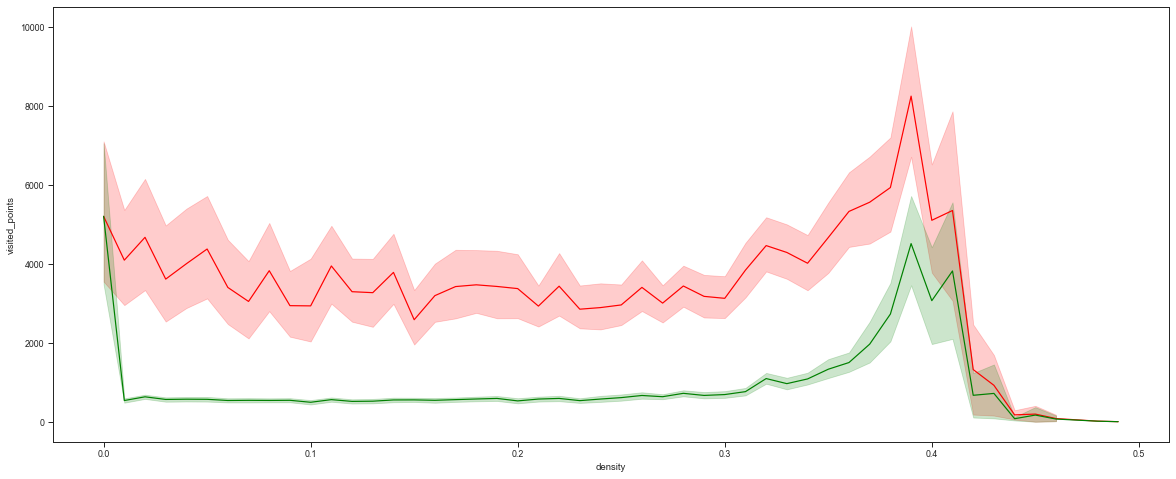

In [1254]:
plt.figure(figsize=(20,8))
sns.lineplot(x="density", y="visited_points", data=df_astar, color="red")
sns.lineplot(x="density", y="visited_points", data=df_hastar, color="green")
sns.set_context("paper")
plt.show()

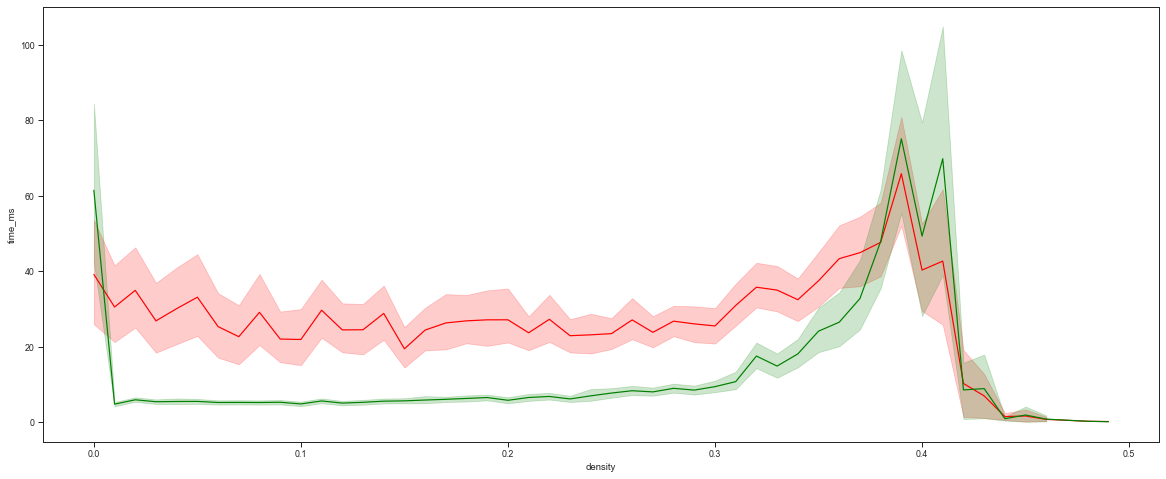

In [1255]:
plt.figure(figsize=(20,8))
#removed_outliers = df["time_ms"].between(df["time_ms"].quantile(.01), df["time_ms"].quantile(.99))
snsplot = sns.lineplot(x="density", y="time_ms", data=df_astar, color="red")
snsplot = sns.lineplot(x="density", y="time_ms", data=df_hastar, color="green")
sns.set_context("paper")
plt.show()

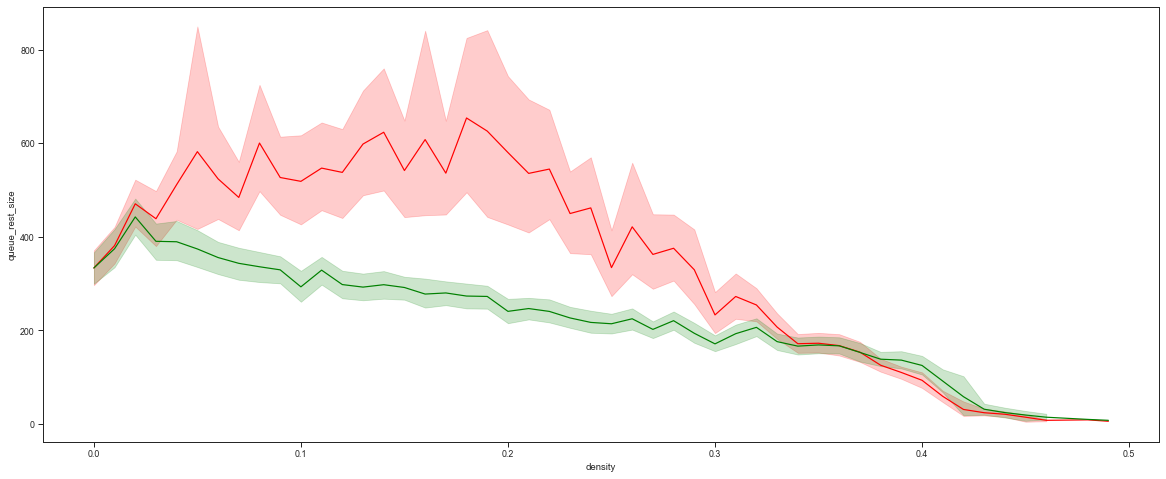

In [1256]:
plt.figure(figsize=(20,8))
sns.lineplot(x="density", y="queue_rest_size", data=df_astar, color="red")
sns.lineplot(x="density", y="queue_rest_size", data=df_hastar, color="green")
sns.set_context("paper")
plt.show()